This is the notebook dedicated to running our models

Gather the dataset and imports

In [1]:
import sys
import os
import torch
import torch.optim as optim
import torch.nn as nn
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data.data_preprocessing import MRIDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import pickle

# Applying random transformations to vary data
transformations = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip()
])

# Data preloaded from pickle file
data_path = os.path.abspath(os.path.join("..", "data", "archive", "brain_tumor_mri", "new_dataset", "training_data.pickle"))
with open(data_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Unpacking the data into the images and their corresponding labels
images, labels = zip(*loaded_data)
dataset = MRIDataset(images, labels, transformations, model_type=None)

# Splitting the dataset into training and testing
training_size = int(.8 * len(dataset))
testing_size = len(dataset) - training_size
training_dataset, testing_dataset = random_split(dataset, [training_size, testing_size])

# Two separate loaders for training and testing
train_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
testing_loader = DataLoader(testing_dataset, batch_size=16, shuffle=True)

# Debug comment out later
for sample_image, sample_label in train_loader:
    print(f"Image shape: {sample_image.shape}")
    print(f"Label: {sample_label}")
    break


Image shape: torch.Size([16, 1, 512, 512, 3])
Label: tensor([3., 3., 2., 3., 3., 3., 1., 3., 3., 2., 2., 1., 2., 2., 1., 2.])


Run the 3D CNN model

In [2]:
from models.CNN_3D.model import CNN_3D
from models.CNN_3D.train import Trainer

# Set up the model, criterion, and optimizer
model = CNN_3D(num_classes=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

torch.cuda.empty_cache()
torch.cuda.ipc_collect()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

model.load_state_dict(torch.load("models/3D_CNN/checkpoints/cnn_3d.pth"))

# Initialize the Trainer class
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=testing_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
)

#trainer.train()

Run the ResNet model

In [ ]:
from models.ResNet.model import ResNet
from models.ResNet.train import train

model = ResNet()

Run the Inception model

In [ ]:
from models.Inception.model import Inception
from models.Inception.train import train

model = Inception()

Visualize Models

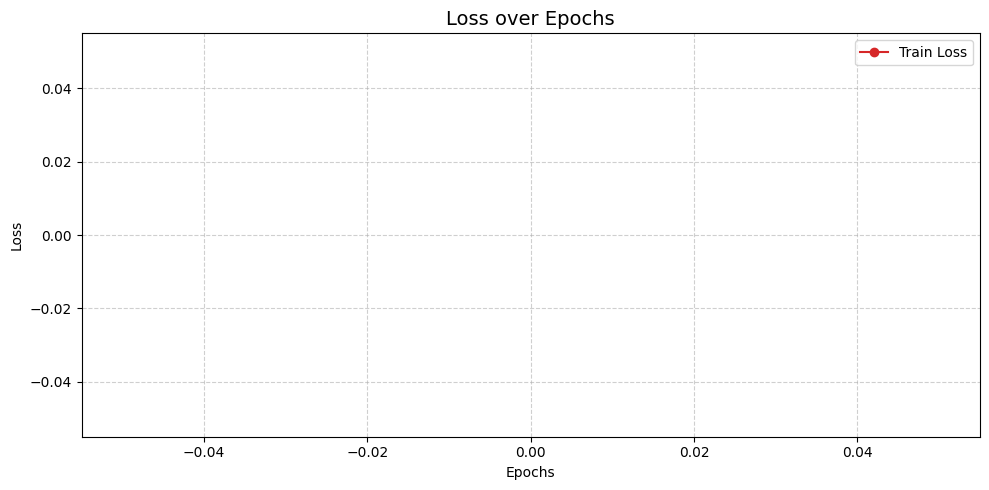

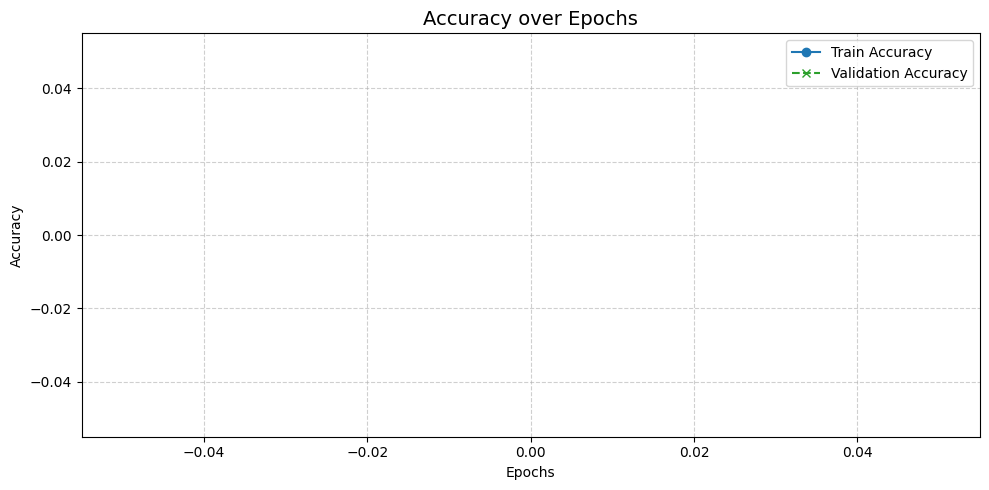

d:\CS 4644 Project\TumorTrace\utils\visualization.py:50: RuntimeWarning: invalid value encountered in divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


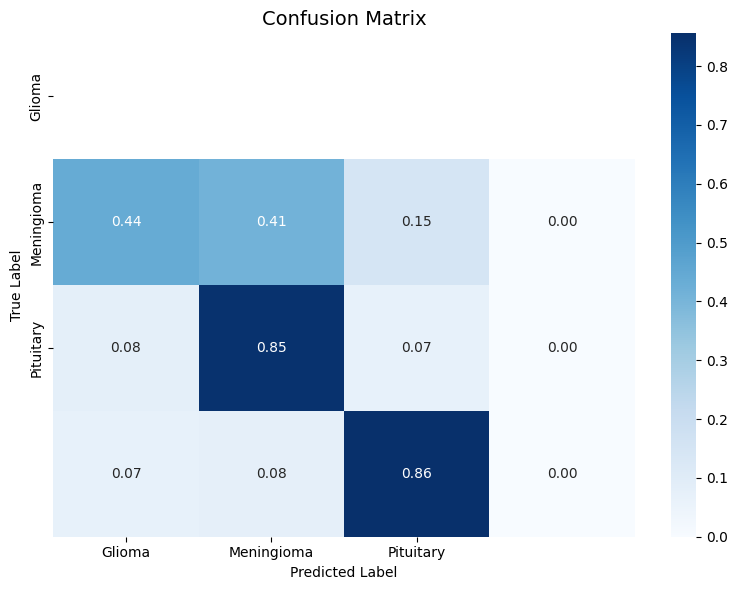


Classification Report:

              precision    recall  f1-score   support

      Glioma       0.63      0.44      0.52       141
  Meningioma       0.75      0.85      0.80       264
   Pituitary       0.82      0.86      0.84       208

    accuracy                           0.76       613
   macro avg       0.73      0.71      0.72       613
weighted avg       0.75      0.76      0.75       613

Saved training plots to results/figures/


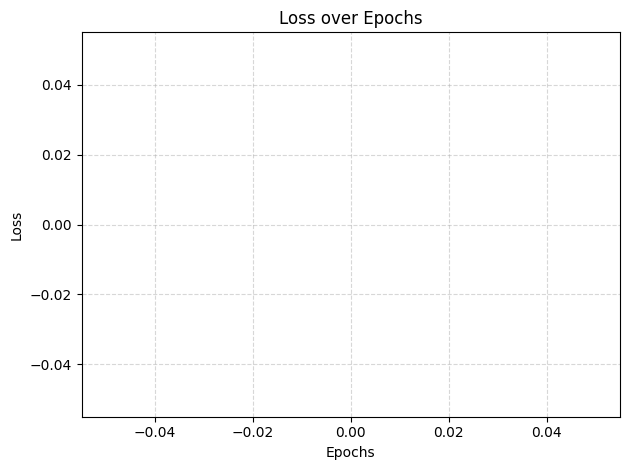

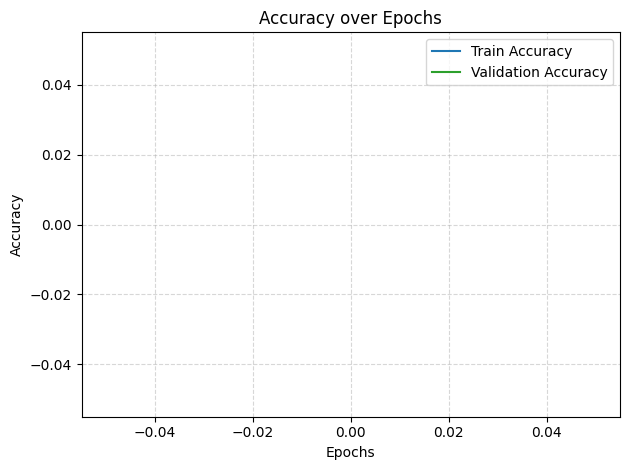

In [3]:
# Plot training curves
trainer.visualizer.plot_loss()
trainer.visualizer.plot_accuracy()

# Re-evaluate model and retrieve predictions
val_accuracy, y_true, y_pred = trainer.evaluate(return_preds=True)

# Visualize confusion matrix and classification report
trainer.visualizer.evaluation_summary(y_true, y_pred)

# Save all plots
trainer.visualizer.save_plots("results/figures/")